# Unit 2: Financial Applications of Time Series
Assignment: Financial Applications of Time Series
+ Choose either the Signal Frontier Analysis application or Future Contract Rolling application.
+ Use different stocks than those shown in examples.
+ Create iPython Notebook, including code, output, and graphics.
+ Include an introduction in your notebook to give background on your application.
+ Be sure to explain calculations and output in the appropriate places.
+ List outside references if used.

# <center>Signal Frontier Analysis</center>
##### <center>Michael Murrietta</center>
##### <center>2018-02-08</center>

### Introduction
Signal frontier analysis purportedly consists of the construction of a cross-sectional momentum (CSM) portfolio. In the CSM portfolio the analyst specifies a period on which to evaluate the stocks in the portfolio and at the end of the period the winning stocks and losing stocks are identified and the appropriate positions on those stocks are taken. The identification process involves specifying a cutoff like 20% where the top 20% are winners and bottom 20% are losers and the middle 60% are ignored. The appropriate positions to take are the long position for winners and the short position for losers. These positions are based on the notion of momentum: the winners will continue to win (long positions bet on an increase), the losers will continue to lose (short positions bet on a decrease).

It should be clear that the lookback period needs to be sufficient to determine any periodicity of oscillations in a stock price but what was not mentioned before is the holding period that follows the evaluation period. The holding period is the period of time that must pass before reversing the held positions on any stocks. This simplification admits a bivariate problem space: what combination of lookback and holding periods maximizes returns?

The time is right to invest in technology but is it worth it to have a portfolio full of tech stocks? Daily close data for Apple (AAPL), Google (GOOG), Amazon (AMZN), Facebook (FB), Microsoft (MSFT), IBM (IBM), Nokia (NOK), Cisco (CSCO), and the Standard and Poor exchange-traded fund (SPY) were collected from 2010-01-01 to 2017-12-31 to form a hypothetical portfolio. A brief look is given to the overall change of the daily closing data then a cross-sectional momentum strategy is examined.

In [1]:
from __future__ import print_function, division
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
%matplotlib inline
plt.style.use('ggplot')

The data is read in which was saved to an Excel workbook after earlier acquisition via the pandas data read and the Google API. Looking at the shape of the data set before and after resampling for all business days revealed 72 dates that were missing but it was not clear if these dates were holidays of some kind so nothing was done to include those days. The start date of the data set was also changed to May 17th, 2012 since FB did not have any close data before then. The plot below shows a mildly interesting battle between AMZN and GOOG to be the best. A second plot was included to highlight what is happening with the other stocks.

Before Resample:
df.shape = (2013, 9)
After Null Delete:
df.shape = (1415, 9)


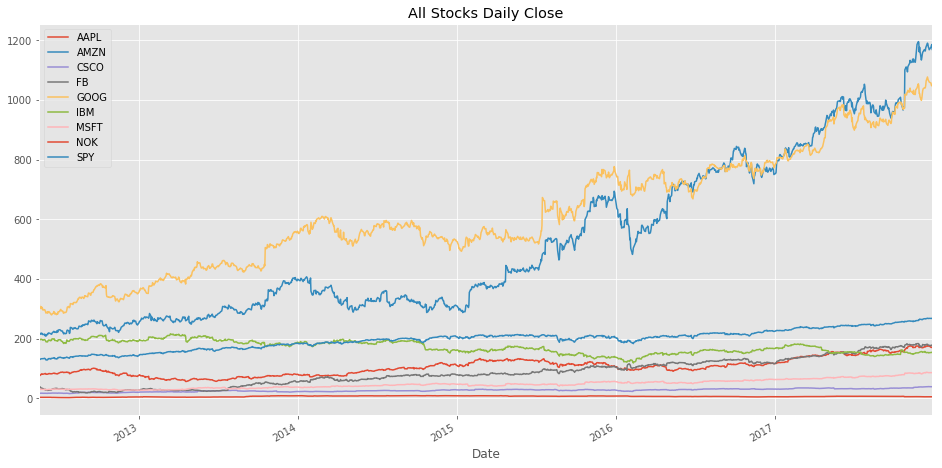

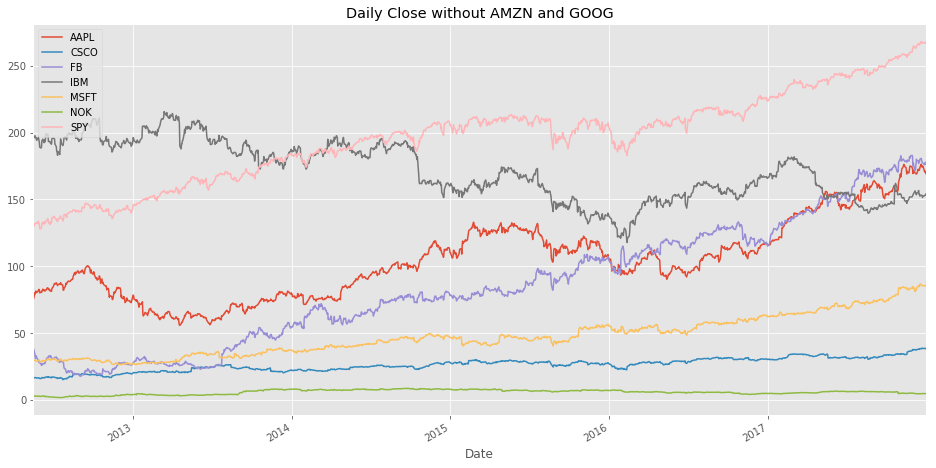

In [2]:
#read in the case study data and the snp data
df = pd.read_excel('the_big_4_plus.xlsx', sheetname='Close', index_col='Date')
print("Before Resample:\ndf.shape = {}".format(df.shape))
# #in case any business days are missing we add them and ffill any missing
# df = df.resample('B').pad()
# print("After Resample:\ndf.shape = {}".format(df.shape))
#also drop some rows since FB didn't appear until May 2017
df = df[df['FB'].isnull()==False]
print("After Null Delete:\ndf.shape = {}".format(df.shape))
# quick plot of df. Its the big 4 plus microsoft and IBM.
# I went with SPY rather than SPX which is apparently the S&P index used with American style options
df.plot(figsize=(16, 8), title="All Stocks Daily Close") #it'd be nice if subplots were this easy with pandas
df[[x for x in df.columns if ((x != 'GOOG') & (x != 'AMZN'))]].plot(figsize=(16,8), 
                                                                   title = "Daily Close without AMZN and GOOG")

The daily close prices themselves are nice to know but more understanding can be gained by looking at the rate at which these prices are chaning. The code below calculates the rate of change between each day and compounds that rate to get the cumulative returns for the time period 2012-05-17 to 2017-12-31. The accompanying plot shows the cumulative returns at each day.

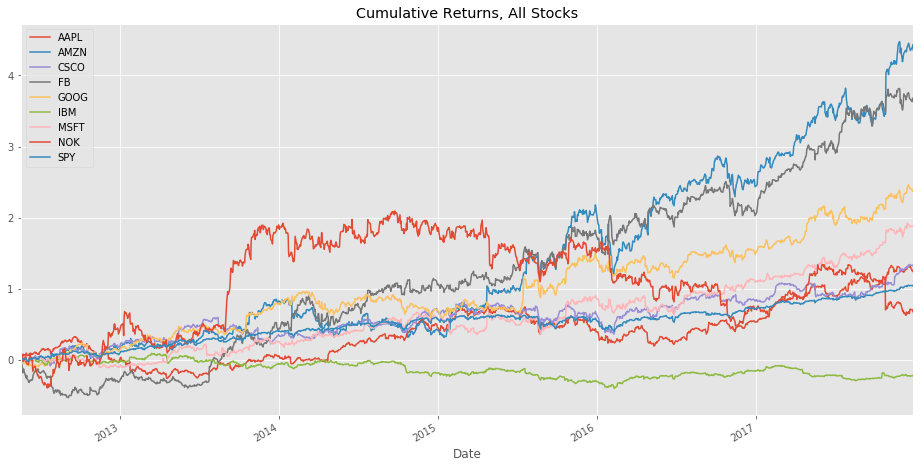

In [3]:
#plotting the cumulative returns for each stock
((1 + df.pct_change()).cumprod() - 1).plot(figsize=(16,8), title='Cumulative Returns, All Stocks')

### Cross Sectional Momentum Strategy
The functions below calculate the overall Sharpe ratio for a portfolio given a particular combination of lookback and holding periods. The Sharpe ratio is a measure of the average return of the portfolio minus the return on risk free investment divided by the standard deviation of return on investment in the portfolio. In this case the return on risk free investment was not used and this absence can be seen in the `daily_sr` function. Also, the cutoff is essentially %50, so all stocks examined during lookback are used in the portfolio during the holding period.
#### Code Explanation
The code below computes the Sharpe ratio by first calculating the cross sectional momentum of the portfolio and also computing the daily percent change of each stock in the portfolio. The lag used when calculating momentum is 1 which is 1 business day in this case and means that the last days worth of data is ignored in the lookback period. The portfolio is then shifted 1 more business day and then resampled for the holding period and finally returning the overall rank for the first x business days of the holding period (where x is the length of business days in the holding period); this is the separation of the winners from the losers. The daily returns for the holding period are also compounded over the holding period. The portfolio returns for each 30 day period are calculated by taking the sum product of the two variables just calculated. Finally the value returned is the daily sharpe ratio divided by the square root of the propotion of the trading year that the holding period covered.

In [4]:
import numpy as np
def calc_mom(price, lookback, lag):
    mom_ret = price.shift(lag).pct_change(lookback)
    ranks = mom_ret.rank(axis=1, ascending=True)
    demeaned = ranks.subtract(ranks.mean(axis=1), axis=0) #old method wasn't working
    return demeaned.divide(demeaned.std(axis=1), axis=0)
compound = lambda x : (1 + x).prod() - 1
daily_sr = lambda x: x.mean() / x.std()
def strat_sr(prices, lb, hold):
    # Compute portfolio weights
    freq = '{}B'.format(hold)
    port = calc_mom(prices, lb, lag=1)
    daily_rets = prices.pct_change()
    # Compute portfolio returns
    port = port.shift(1).resample(freq).first() #warning from new version prompted this change
    returns = daily_rets.resample(freq).apply(compound) #warning from new version prompted this change
    port_rets = (port * returns).sum(axis=1)
    return daily_sr(port_rets) * np.sqrt(252 / hold)

### Lookback and Holding period Raster Search
The code below simply creates a data frame that consists of the Sharpe ratio as explained above for this portfolio using different combinations of lookback periods and holding periods between 20 and 90 days spaced by 5 days. A heat map is produced based on this data frame and highlights the most profitable combination as being a 30 day lookback period with a 75 day holding period.

In [5]:
from collections import defaultdict
lookbacks = range(20, 90, 5)
holdings = range(20, 90, 5)
dd = defaultdict(dict)
for lb in lookbacks:
    for hold in holdings:
        dd[lb][hold] = strat_sr(df, lb, hold)
ddf = pd.DataFrame(dd)
ddf.index.name = 'Holding Period'
ddf.columns.name = 'Lookback Period'

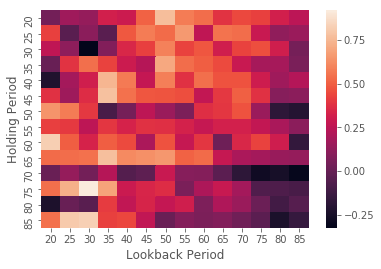

In [6]:
#heatmap to help visualize what the best combinations of holding period and lookback period were
#looks like (lookback, holding) = (55, 75) is best
import seaborn as sns
sns.heatmap(ddf)

### Comparing on Different Date Ranges
The code above uses the entire date range to determine the Sharpe ratio but how do smaller time intervals compare to this nearly 5 year span of stock data? Below the date range is split nearly in half (708 days and 707 days) and the holdout-lookback period space is again explored. The optimum combination for each half is not the same as for the longer time period. In the first half the 30 day lookback with 75 day holding period produces a decent result but not the best. In the second half the same combination produces a result that is less than halfway up the spectrum of outputs. It is useful to note that the second half has a minimum Sharpe ratio of 0.097 while the first half has a minimum of -0.723; the larger date range is somewhere in the middle at -0.325. There are some similarities however as the bottom right corner (high end of both the lookback and holding period spectra) seems to produce a lower Sharpe ratio in both halves of the date range.

In [7]:
#split the data set in half, we need contiguous halves of course since this is a time-series
# df.iloc[int(df.shape[0]/2)]
dfs = [df.loc[:'2015-03-12'], df.loc['2015-03-13':]]

In [8]:
#grid search the lookback-holding period space for each data frame
dds = [pd.DataFrame([[strat_sr(sdf, x, y) for x in range(20, 90, 5)] for y in range(20, 90, 5)], 
             index=range(20, 90, 5), columns=range(20, 90, 5)) for sdf in dfs]
for i in range(2):
    dds[i].index.name = 'Holding Period'
    dds[i].columns.name = 'Lookback Period'

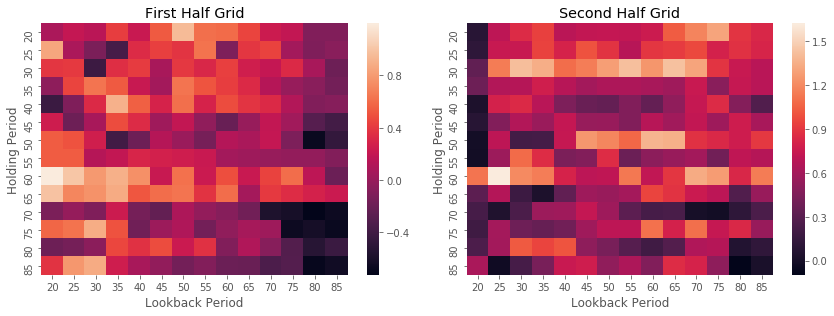

In [9]:
fig,axn = plt.subplots(1, 2, figsize=(12, 4.5))
ttls = ['First Half Grid', 'Second Half Grid']
for dd, ax, ttl in zip(dds, axn.flat, ttls):
    axs = sns.heatmap(dd, ax=ax)
    axs.set_title(ttl)
fig.tight_layout()